In [11]:
from pyspark.sql import SparkSession, DataFrame, Row
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import explode, col, isnan, count, when, round, collect_list
from pyspark.mllib.stat import Statistics
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler, StringIndexer, ChiSqSelector
from sklearn.model_selection import train_test_split
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression,RandomForestClassifier,\
LinearSVC, MultilayerPerceptronClassifier, OneVsRest, NaiveBayes,DecisionTreeClassifier
from pyspark.ml import Pipeline, PipelineModel
import pandas as pd
from pyspark.sql.functions import lit
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pickle
%matplotlib inline

In [12]:
path = 'E:\\Downloads\\diabetes_dataset\\offline.csv'
k = 5
max_parallelism = 6

In [13]:
spark = SparkSession.builder.master("local[*]") \
.config("spark.executor.memory", "8g")\
.config("spark.driver.memory", "8g")\
        .appName('HW_3').getOrCreate()

# Read the dataset

In [14]:
df = spark.read.csv(path, inferSchema=True, encoding='utf-8', header=True)
df.cache()
df.toPandas()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,Diabetes_012
0,0,1,1,29,0,0,1,1,1,1,...,0,2,0,0,0,1,8,6,8,0
1,0,0,1,24,0,0,0,1,0,1,...,0,3,1,4,0,0,9,6,8,0
2,1,1,1,42,0,1,1,1,1,1,...,0,3,20,3,1,1,9,6,7,0
3,1,0,1,21,1,0,0,0,1,1,...,0,2,0,0,0,1,10,5,7,0
4,0,0,1,29,1,0,0,1,1,1,...,1,3,14,0,0,1,2,4,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202939,0,0,1,26,0,0,0,1,1,1,...,0,1,1,0,0,1,1,5,8,0
202940,1,1,1,25,1,0,0,1,0,1,...,0,4,0,0,0,1,9,6,5,0
202941,0,1,1,35,1,0,0,1,1,1,...,0,2,4,0,0,0,6,6,6,0
202942,0,0,1,28,0,0,0,1,0,1,...,0,2,0,1,0,0,6,6,8,0


In [15]:
num_classes = df.select('Diabetes_012').distinct().count()
print(f"Number of classes: {num_classes}")

Number of classes: 3


# Create a pipeline of preprocessing tools

In [21]:
pipeline = Pipeline(stages = [])

In [22]:
assembler = VectorAssembler()\
    .setInputCols(df.drop(*['Diabetes_012']).columns)\
    .setOutputCol('features') 

In [23]:
indexer = StringIndexer(stringOrderType='alphabetAsc')\
    .setInputCol('Diabetes_012')\
    .setOutputCol('label')

In [24]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction",
    probabilityCol="probability")

In [25]:
pipeline.setStages([indexer, assembler])

Pipeline_1cb42531dfb8

In [26]:
df = pipeline.fit(df).transform(df)
df.show()

+------+--------+---------+---+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+---+---+---------+------+------------+-----+--------------------+
|HighBP|HighChol|CholCheck|BMI|Smoker|Stroke|HeartDiseaseorAttack|PhysActivity|Fruits|Veggies|HvyAlcoholConsump|AnyHealthcare|NoDocbcCost|GenHlth|MentHlth|PhysHlth|DiffWalk|Sex|Age|Education|Income|Diabetes_012|label|            features|
+------+--------+---------+---+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+---+---+---------+------+------------+-----+--------------------+
|     0|       1|        1| 29|     0|     0|                   1|           1|     1|      1|                0|            1|          0|      2|       0|       0|       0|  1|  8|        6|     8|           0|  0.0|[0.0,1.0,1.0,29.0...|
|     0|       0|        1| 24|     0|     0

# Feature Selection using Random Forest Classifier

## Defining parameter search space 

In [27]:
rfc = RandomForestClassifier()
max_depth = [5, 10, 20]
max_bins = [10, 20, 50]
num_trees = [10, 20, 50]
criterion = ['gini', 'entropy']

In [28]:
rfc_param_grid = (ParamGridBuilder()\
            .addGrid(rfc.maxDepth, max_depth)\
            .addGrid(rfc.maxBins, max_bins)\
            .addGrid(rfc.numTrees,num_trees)\
            .addGrid(rfc.impurity, criterion))\
            .build()

## Estimating the best parameter values for our random forest classifier using K-fold cross validation

In [29]:
rfc_cv = CrossValidator(estimator=rfc, 
                       estimatorParamMaps=rfc_param_grid,
                       evaluator=evaluator,
                       numFolds=k,
                       parallelism=max_parallelism) 

In [30]:
fitModel = rfc_cv.fit(df)

In [31]:
print(f"Random Forest Classifier {k}-fold average f1 score: {max(fitModel.avgMetrics)}")

Random Forest Classifier 5-fold average f1 score: 0.8098911174093436


In [56]:
best_model= fitModel.bestModel
feature_importances= best_model.featureImportances
feature_importances

SparseVector(21, {0: 0.0641, 1: 0.0347, 2: 0.0047, 3: 0.1426, 4: 0.0258, 5: 0.015, 6: 0.0215, 7: 0.027, 8: 0.0301, 9: 0.0268, 10: 0.0099, 11: 0.0116, 12: 0.0186, 13: 0.0941, 14: 0.0679, 15: 0.0881, 16: 0.0273, 17: 0.0283, 18: 0.1086, 19: 0.064, 20: 0.0891})

In [57]:
def extract_rf_params_to_dict(rf: RandomForestClassifier) -> dict:
    return {
        "maxDepth" : rf.getMaxDepth(),
        "maxBins" : rf.getMaxBins(),
        "numTrees": rf.getNumTrees(),
        "impurity": rf.getImpurity()
    }

In [58]:
extract_rf_params_to_dict(rfc)

{'maxDepth': 5, 'maxBins': 32, 'numTrees': 20, 'impurity': 'gini'}

## Feature importances of diabetes dataset

In [59]:
feature_importances = [float(importance) for importance in list(feature_importances.toArray())]

In [107]:
feature_importances_list = []
for column_name, importance in zip(df.columns, feature_importances):
    feature_importances_list.append(
    {
        'column_name' : column_name,
        'importance': importance
    })

df_feature_importances = spark.createDataFrame(feature_importances_list).orderBy(col('importance').desc())
df_feature_importances.show(len(df.columns))

+--------------------+--------------------+
|         column_name|          importance|
+--------------------+--------------------+
|                 BMI|  0.1426388130243297|
|                 Age| 0.10862794136216941|
|             GenHlth| 0.09414758187655012|
|              Income| 0.08905104378839711|
|            PhysHlth| 0.08808942108968291|
|            MentHlth|  0.0679042325270357|
|              HighBP| 0.06411785602808381|
|           Education|  0.0639524832181708|
|            HighChol|0.034744327618510346|
|              Fruits| 0.03010075123710515|
|                 Sex|0.028300542547187963|
|            DiffWalk| 0.02732566305991393|
|        PhysActivity|0.027017337899714916|
|             Veggies| 0.02684537696597828|
|              Smoker|0.025843389725908456|
|HeartDiseaseorAttack|0.021549669686759303|
|         NoDocbcCost|0.018558554188952806|
|              Stroke|0.015001329706997189|
|       AnyHealthcare|0.011566069156734011|
|   HvyAlcoholConsump|0.00989716

## Correlation matrix of diabetes dataset

<AxesSubplot:>

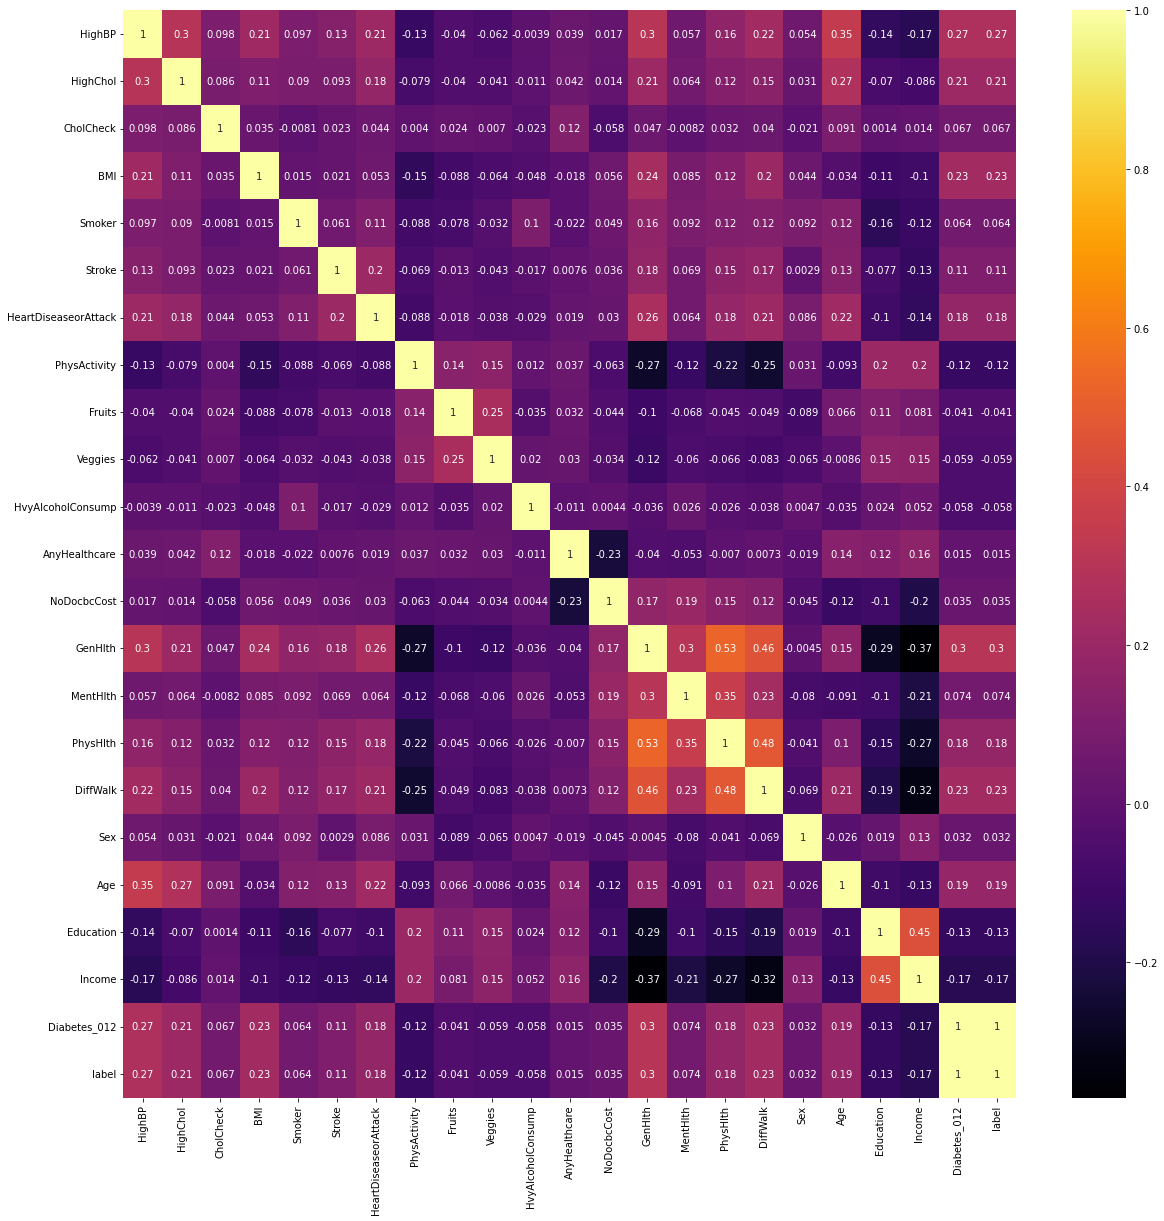

In [108]:
corr_matrix = df.toPandas().corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, cmap='inferno', annot=True)

In [109]:
target_columns = ['Diabetes_012', 'label']

In [110]:
df_corr = spark.createDataFrame([Row(
    column_name = col_name, 
    correlation_with_target = abs(float(corr)))\
    for col_name, corr in dict(corr_matrix['Diabetes_012']).items() if col_name not in target_columns])\
.orderBy(col('correlation_with_target').desc())

In [111]:
df_corr.show(len(df.columns))

+--------------------+-----------------------+
|         column_name|correlation_with_target|
+--------------------+-----------------------+
|             GenHlth|    0.30373360659390164|
|              HighBP|    0.27133072374011824|
|            DiffWalk|    0.22666254928162488|
|                 BMI|     0.2263847871374511|
|            HighChol|    0.20899529732587768|
|                 Age|    0.18522723188468387|
|HeartDiseaseorAttack|    0.18004509220769804|
|            PhysHlth|    0.17693497894261823|
|              Income|     0.1722265754507259|
|           Education|     0.1310661830385917|
|        PhysActivity|     0.1240630934416769|
|              Stroke|    0.10841920299221135|
|            MentHlth|    0.07378023189280437|
|           CholCheck|    0.06744984800081406|
|              Smoker|    0.06402219081374967|
|             Veggies|   0.059412570085447966|
|   HvyAlcoholConsump|    0.05788532264240895|
|              Fruits|    0.04109195068048432|
|         NoD

## Merging both dataframes

In [112]:
df_variable_importance = \
df_feature_importances.join(df_corr, ['column_name'])\
.orderBy(col('importance').desc(), col('correlation_with_target').desc())\
.withColumn('importance', round('importance', 3))\
.withColumn('correlation_with_target', round('correlation_with_target', 3))

In [113]:
df_variable_importance.show()

+--------------------+----------+-----------------------+
|         column_name|importance|correlation_with_target|
+--------------------+----------+-----------------------+
|                 BMI|     0.143|                  0.226|
|                 Age|     0.109|                  0.185|
|             GenHlth|     0.094|                  0.304|
|              Income|     0.089|                  0.172|
|            PhysHlth|     0.088|                  0.177|
|            MentHlth|     0.068|                  0.074|
|              HighBP|     0.064|                  0.271|
|           Education|     0.064|                  0.131|
|            HighChol|     0.035|                  0.209|
|              Fruits|      0.03|                  0.041|
|                 Sex|     0.028|                  0.032|
|            DiffWalk|     0.027|                  0.227|
|        PhysActivity|     0.027|                  0.124|
|             Veggies|     0.027|                  0.059|
|             

## Drop columns with low importance

Drop the attributes with importance lower than 0.02 and correlation lower than 0.1

In [137]:
df_variable_importance = df_variable_importance.where(col('importance') > .02).where(col('correlation_with_target') > .1)

In [139]:
df_variable_importance.show()

+--------------------+----------+-----------------------+
|         column_name|importance|correlation_with_target|
+--------------------+----------+-----------------------+
|                 BMI|     0.143|                  0.226|
|                 Age|     0.109|                  0.185|
|             GenHlth|     0.094|                  0.304|
|              Income|     0.089|                  0.172|
|            PhysHlth|     0.088|                  0.177|
|              HighBP|     0.064|                  0.271|
|           Education|     0.064|                  0.131|
|            HighChol|     0.035|                  0.209|
|            DiffWalk|     0.027|                  0.227|
|        PhysActivity|     0.027|                  0.124|
|HeartDiseaseorAttack|     0.022|                   0.18|
+--------------------+----------+-----------------------+



In [140]:
df_variable_importance.toPandas().to_csv("variable_importance.csv")

## Estimating the best features based on model performances

### 1. Define baseline models

In [141]:
def get_baseline_cross_validator(estimator) -> CrossValidator:
    return  CrossValidator(
    evaluator=evaluator,
    estimatorParamMaps=ParamGridBuilder().build(),
    estimator=estimator,
    numFolds=k,
    parallelism=max_parallelism
)

In [142]:
candidate_datasets = []

In [143]:
cv_models = {
    'naive_bayes' : get_baseline_cross_validator(NaiveBayes()),
    'logistic_regression' : get_baseline_cross_validator(LogisticRegression()),
    'decision_tree' : get_baseline_cross_validator(DecisionTreeClassifier())
}

### 2. Evaluate the 5-fold average cross validation f1 score for each model and each dataset containing the top n most important features

In [144]:
for n in list(range(1, df_variable_importance.count()+1)):
    for model_name, cv_model in cv_models.items():
        
        df_i = df.select([row.column_name for row in df_variable_importance.select('column_name').take(n)] + ['Diabetes_012'])
    
        assembler = VectorAssembler()\
        .setInputCols(df_i.drop('Diabetes_012').columns)\
        .setOutputCol('features')     
    
        df_i = Pipeline(stages = [assembler,indexer]).fit(df_i).transform(df_i)
   
        model = cv_model.fit(df_i)
        candidate_datasets.append({
            'top_n_features': n,
            f'{k}_fold_average_{evaluator.getMetricName()}_score': model.avgMetrics[0],
            'model_name' : model_name,
        })


candidate_datasets 

[{'top_n_features': 1,
  '5_fold_average_f1_score': 0.7703515244531858,
  'model_name': 'naive_bayes'},
 {'top_n_features': 1,
  '5_fold_average_f1_score': 0.7736340258601799,
  'model_name': 'logistic_regression'},
 {'top_n_features': 1,
  '5_fold_average_f1_score': 0.7703515244531858,
  'model_name': 'decision_tree'},
 {'top_n_features': 2,
  '5_fold_average_f1_score': 0.7703515244531858,
  'model_name': 'naive_bayes'},
 {'top_n_features': 2,
  '5_fold_average_f1_score': 0.7793910997307623,
  'model_name': 'logistic_regression'},
 {'top_n_features': 2,
  '5_fold_average_f1_score': 0.7738820618970933,
  'model_name': 'decision_tree'},
 {'top_n_features': 3,
  '5_fold_average_f1_score': 0.7703515244531858,
  'model_name': 'naive_bayes'},
 {'top_n_features': 3,
  '5_fold_average_f1_score': 0.7963895695562578,
  'model_name': 'logistic_regression'},
 {'top_n_features': 3,
  '5_fold_average_f1_score': 0.7956790568433839,
  'model_name': 'decision_tree'},
 {'top_n_features': 4,
  '5_fold_a

In [145]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
        print(pd.DataFrame(candidate_datasets).sort_values(['5_fold_average_f1_score', 'top_n_features'], ascending=[False, True]))

    top_n_features  5_fold_average_f1_score           model_name
31              11                    0.807  logistic_regression
28              10                    0.806  logistic_regression
25               9                    0.806  logistic_regression
22               8                    0.806  logistic_regression
17               6                    0.805        decision_tree
20               7                    0.805        decision_tree
23               8                    0.802        decision_tree
26               9                    0.802        decision_tree
29              10                    0.802        decision_tree
32              11                    0.802        decision_tree
19               7                    0.802  logistic_regression
16               6                    0.802  logistic_regression
10               4                    0.797  logistic_regression
13               5                    0.797  logistic_regression
7                3       

In [146]:
pd.DataFrame(candidate_datasets).to_csv('model_performance.csv')

### 3. Choose the best number of features

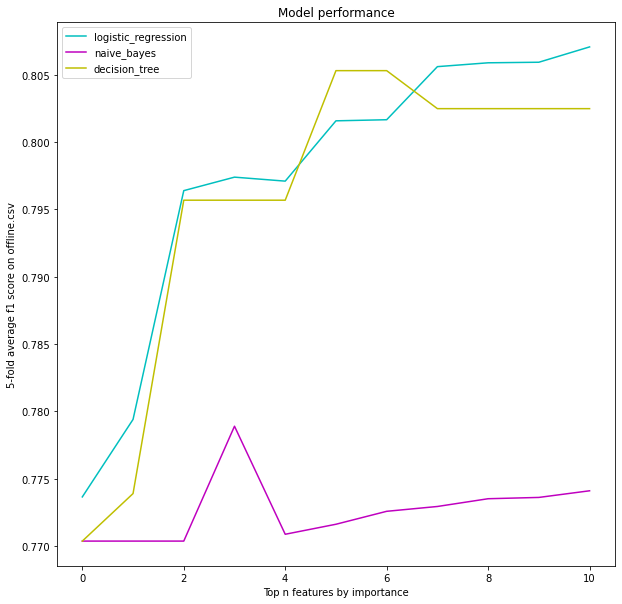

In [147]:
plt.figure(figsize=(10, 10))
labels = list(set([entry['model_name'] for entry in candidate_datasets]))
colors = ['c', 'm', 'y']
for label, color in zip(labels, colors):
    plt.plot([entry['5_fold_average_f1_score'] for entry in candidate_datasets if entry['model_name'] == label], color=color, label=label)
plt.legend()
plt.title("Model performance")
plt.xlabel("Top n features by importance")
plt.ylabel("5-fold average f1 score on offline.csv")
plt.show()

From this figure we can infer that most of the models achieve the best performance when n = 8 (the 8 most important features are chosen from the selected features dataframe).An exception is the Naive Bayes model which achieves it's highest score when n = 3. If we search for the biggest "elbow/knee" in this figure, we can see that the 5-fold average f1 score has it's biggest increase when n is 8 (from n is 6). 

In [148]:
best_top_n = 8

In [149]:
df_selected_features = df\
    .select([row.column_name for row in df_variable_importance.select('column_name').take(best_top_n)] + ['Diabetes_012'])

assembler = VectorAssembler()\
        .setInputCols(df_selected_features.drop('Diabetes_012').columns)\
        .setOutputCol('features')   

pipeline.setStages([indexer, assembler])
df_selected_features = pipeline.fit(df_selected_features).transform(df_selected_features)
df_selected_features.show()

+---+---+-------+------+--------+------+---------+--------+------------+-----+--------------------+
|BMI|Age|GenHlth|Income|PhysHlth|HighBP|Education|HighChol|Diabetes_012|label|            features|
+---+---+-------+------+--------+------+---------+--------+------------+-----+--------------------+
| 29|  8|      2|     8|       0|     0|        6|       1|           0|  0.0|[29.0,8.0,2.0,8.0...|
| 24|  9|      3|     8|       4|     0|        6|       0|           0|  0.0|[24.0,9.0,3.0,8.0...|
| 42|  9|      3|     7|       3|     1|        6|       1|           0|  0.0|[42.0,9.0,3.0,7.0...|
| 21| 10|      2|     7|       0|     1|        5|       0|           0|  0.0|[21.0,10.0,2.0,7....|
| 29|  2|      3|     3|       0|     0|        4|       0|           0|  0.0|[29.0,2.0,3.0,3.0...|
| 28|  4|      2|     8|       7|     0|        5|       0|           0|  0.0|[28.0,4.0,2.0,8.0...|
| 30|  9|      2|     8|       0|     1|        5|       0|           0|  0.0|[30.0,9.0,2.0,8.0...|


# Hyperparameter tuning 

### Define parameter search space

In [150]:
lr = LogisticRegression()
dt = DecisionTreeClassifier()
nb = NaiveBayes()

In [151]:
lr_max_iter = [100, 200, 500]
lr_fit_intercept = [True, False]
lr_reg_param = [0, .1, .01]

dt_max_depth = [10, 20, 30]
dt_max_bins = [10, 20, 50]
dt_criterion = ['gini', 'entropy']


nb_smoothing = [0, 1, 2, 3]




In [152]:
lr_param_grid = (ParamGridBuilder()\
    .addGrid(lr.maxIter, lr_max_iter)\
    .addGrid(lr.fitIntercept, lr_fit_intercept)\
    .addGrid(lr.regParam,lr_reg_param))\
    .build()

dt_param_grid = (ParamGridBuilder()\
    .addGrid(dt.maxDepth, dt_max_depth)\
    .addGrid(dt.maxBins, dt_max_bins)\
    .addGrid(dt.impurity,dt_criterion))\
    .build()

nb_param_grid = (ParamGridBuilder()\
    .addGrid(nb.smoothing, nb_smoothing))\
    .build()

In [153]:
def extract_lr_params_to_dict(lr: LogisticRegression) -> dict:
    return {
        "maxIter" : lr.getMaxIter(),
        "fitIntercept" : lr.getFitIntercept(),
        "regParam": lr.getRegParam()
    }

def extract_dt_params_to_dict(dt: DecisionTreeClassifier) -> dict:
    return {
        "maxDepth": dt.getMaxDepth(),
        "maxBins" : dt.getMaxBins(),
        "impurity": dt.getImpurity(),
    }

def extract_nb_params_to_dict(nb: NaiveBayes) -> dict:
    return {
        "smoothing" : nb.getSmoothing(),
    }

In [154]:
cv_models['logistic_regression'] = CrossValidator(estimator=lr,
                                                 estimatorParamMaps=lr_param_grid,
                                                 evaluator=evaluator,
                                                 numFolds=k,
                                                 parallelism=max_parallelism
                                                 )
cv_models['naive_bayes'] = CrossValidator(estimator=nb,
                                                 estimatorParamMaps=nb_param_grid,
                                                 evaluator=evaluator,
                                                 numFolds=k,
                                                 parallelism=max_parallelism)
cv_models['decision_tree'] = CrossValidator(estimator=dt,
                                                 estimatorParamMaps=dt_param_grid,
                                                 evaluator=evaluator,
                                                 numFolds=k,
                                                 parallelism=max_parallelism)


cv_models

{'naive_bayes': CrossValidator_a5c12920820e,
 'logistic_regression': CrossValidator_c6e31d8f64bc,
 'decision_tree': CrossValidator_d91be8092db7}

### Save the best models

In [155]:
for model_name, cv_model in cv_models.items():
    
    fitted_model = cv_model.fit(df_selected_features)
    print(f'Best {model_name} model 5-fold average f1 score: {max(fitted_model.avgMetrics)}')
    if model_name == 'logistic_regression':
        
        with open ('lr_param.pkl', 'wb') as f:
            pickle.dump(extract_lr_params_to_dict(fitted_model.bestModel), f)
        
    elif model_name == 'decision_tree':
        
        with open ('dt_param.pkl', 'wb') as f:
            pickle.dump(extract_dt_params_to_dict(fitted_model.bestModel), f)
        
    else:
        with open ('nb_param.pkl', 'wb') as f:
            pickle.dump(extract_nb_params_to_dict(fitted_model.bestModel), f)
    

Best naive_bayes model 5-fold average f1 score: 0.7729229939195893
Best logistic_regression model 5-fold average f1 score: 0.8056021183619109
Best decision_tree model 5-fold average f1 score: 0.8077365799685875


In [156]:
files = {'logistic_regression':'lr_param.pkl',
         'decision_tree': 'dt_param.pkl', 
         'naive_bayes': 'nb_param.pkl'}
for model_name, file in files.items():
    with open(file, 'rb') as f:
        print(f"{model_name} best model parameters: {pickle.load(f)}")

logistic_regression best model parameters: {'maxIter': 100, 'fitIntercept': True, 'regParam': 0.0}
decision_tree best model parameters: {'maxDepth': 10, 'maxBins': 20, 'impurity': 'gini'}
naive_bayes best model parameters: {'smoothing': 0.0}
